# How To Forecast Time-Series Using Autoregression


## Intro


In my previous posts we have covered autoregession (AR) and moving-average (MA) models. However, do you know what is better than these two models? A single model that combines them!

Autoregressive Integrated Moving Average better known as ARIMA, is probably the most used time series forecasting model and is combination of the individual aforementioned models.

In this article, I want to dive into the theory and framework behind the ARIMA model. Then, we will go through a simple Python walkthrough in carrying out forecast with ARIMA using the statsmodels package!


## What Is Moving Average Mode?



### Overview

As stated above, ARIMA stands for AutoRegressive Integrated Moving Average is basically just a combination of the three (in reality two) components:


**AutoRegressive (AR):**

This is just autoregression, where we forecast future values using a linear combination of the previously observed values:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t
$$

Here y is the time series we are forecasting at multiple time steps, ϕ are the coefficients of the lags, ε is the error term (often normally distributed) and p is the number of lagged components, also known as the order.

**Integrated (I):**

The middle part of the ARIMA model is named integrated. This is the number (order d) of differencing required to make the time series stationary.

Stationarity is where the time series has a constant mean and variance, meaning the statistical properties of the series does not change through time. Differencing de-trends a time series and tends to make the mean constant. You can apply differencing several times, but often the series is sufficiently stationary after a single differencing step.

It is important to note, that this integrated part only makes the mean constant. We need to apply another transform such as the logarithmic and Box-Cox transform to generate a constant variance (more on this later).

**Moving Average (MA):**

The last component is the moving average where you forecast using past forecast errors instead of the actual observed values:

$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}
$$

Here y is the time series we are forecasting at multiple time steps, μ is the mean, θ are the coefficients of the lagged forecast errors, ε are the forecast error terms and q is the number of lagged error components.


**Final Form:**

Combining all these components together, we can write the full model as:


$$
y_t' = c + \phi_1 y_{t-1}' + \cdots + \phi_p y_{t-p}' + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}
$$

Where y’ refers to the differenced version of the time series.

This is the full ARIMA equation and is just a linear summation of the three components. The model is usefully written in a short-hand way as ARIMA(p, d, q) where p, d and q refer to the order of autoregressors, differencing and moving-averages components respectively.

### Requirements

As we touched upon earlier, the differencing component is there to help make the time series stationary. This is because the ARIMA model requires the data to be stationary for it to adequately model it. The mean is stabilised through differencing and the variance can be stabilised through the Box-Cox transform as we mentioned above.


### Order Selection

One of the preprocessing steps is to determine the optimal orders (p, d, q) of our ARIMA model. The simplest one is the order of differencing d as this can be verified by carrying out a statistical test for stationarity. The most popular one is the Augmented Dickey-Fuller (ADF), where the null hypothesis is that the time series is not stationary.

The autoregressive and moving-average orders (p,q) can be deduced by analysing the partial autocorrelation function (PACF) and autocorrelation function respectively. The gist of of this method is to plot a correlogram of the various lags/forecast errors of the time series to determine which are statistically significant. If this seems arbitrary at the moment don’t worry, in the Python tutorial later we will walkthrough this process.

However, a more thorough technique is to simply iterate over all the possible combinations of orders and choose the model with the best score against a metric such as Akaike’s Information Criterion (AIC) or Bayesian Information Criterion (BIC). This is analogous to regular hyperparameter tuning and definitely the more robust method, but is more computational expensive of course.


### Estimation

After choosing our orders, we then need to find their optimal corresponding coefficients. This where the need for stationarity comes in. As declared above, a stationary time series has constant statistical properties such as mean and variance. Therefore, all the data points are part of the same probability distribution, which makes fitting our model easier. Furthermore, forecasts are treated as random variables and will now belong to the same probability distribution as the newly generated stationary time series. Overall, it helps make the data in the future be somewhat like the past.

As the stationary data belongs to some distribution (frequently the normal distribution), we can estimate the coefficients using Maximum Likelihood Estimation (MLE). MLE deduces the optimal values of the coefficients that produce the highest probability of obtaining that data. The MLE for normally distributed data, is the same result as carrying ordinary least squares. Therefore, least squares is also frequently used for this exact reason.

## Python Walkthrough



### Data

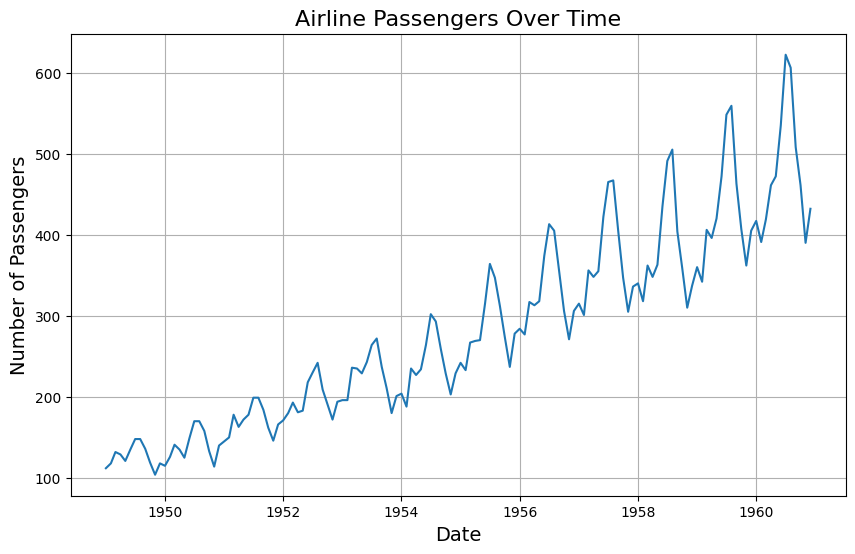

In [7]:
# Import packages
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Read in the data
path = kagglehub.dataset_download("ashfakyeafi/air-passenger-data-for-time-series-analysis")
data = pd.read_csv(path + "/AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    plt.figure(figsize=(10, 6))
    plt.plot(df['Month'], df[y])
    plt.title('Airline Passengers Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Passengers', fontsize=14)
    plt.grid(True)
    plt.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

The data is not stationary as there is a strong positive trend and the yearly seasonality fluctuations are increasing through time, hence the variance is increasing. For this modelling task we will be using the statsmodel package, which handily carries out differencing for us and produces a constant mean. However, we still need to apply the Box-Cox transform to retrieve a stabilised variance:

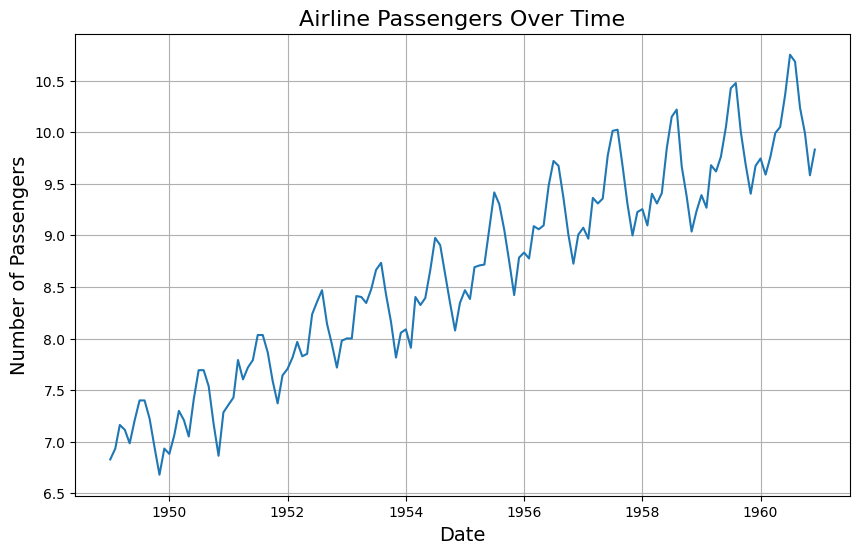

In [8]:
# Import packages 
from scipy.stats import boxcox

# Make the target variance stationary
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])

# Plot the box-cox passenger data
plot_passenger_volumes(df=data, y='Passengers_Boxcox')

The data now appears to be stationary. We could have made it further stationary by carrying out second order differencing or seasonal differencing, however I think it is satisfactory here.

### Modelling

In the previous sections, I mentioned how you can find the autoregressive and moving-average orders by plotting the autocorrelation and partial autocorrelation functions. Let’s show an example of how you can do it here:

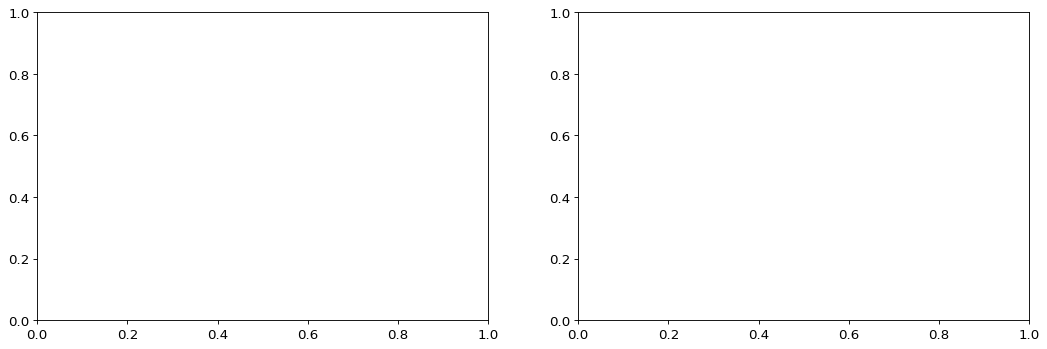

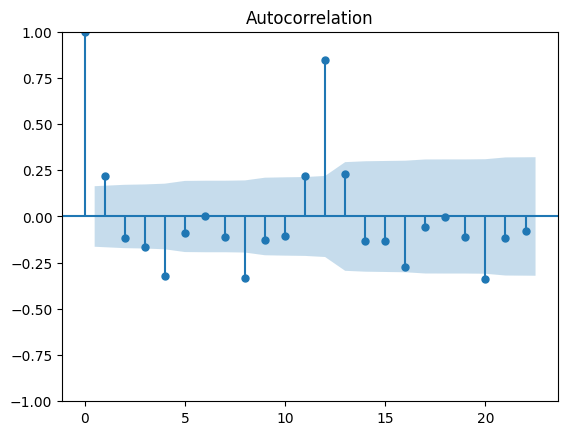

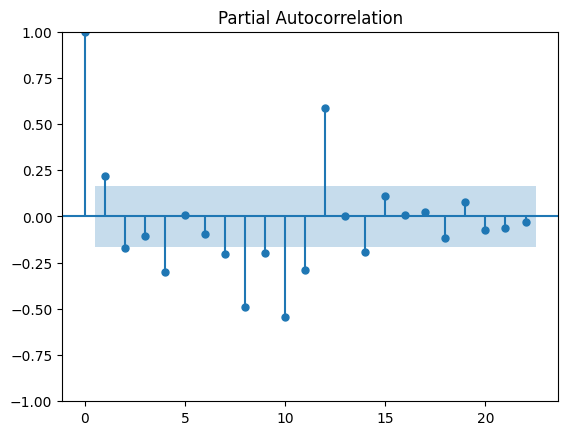

In [9]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data["Passenger_diff"] = data["Passengers_Boxcox"].diff()
data.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data['Passenger_diff'])
plot_pacf(data['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

The blue region signifies where the points are no longer statistically significant and from the plot we see the last lag that is statistically significant for both plot is ~12th. Therefore, we would take the order of p and q to be 12.

Now, let’s fit the model using the ARIMA function and generate the forecasts:

In [12]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Passengers_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/Users/amirashrafizham/Desktop/Machine Learning Projects/time-series/time-series-models/statisticalmodel/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for fore

### Results

The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

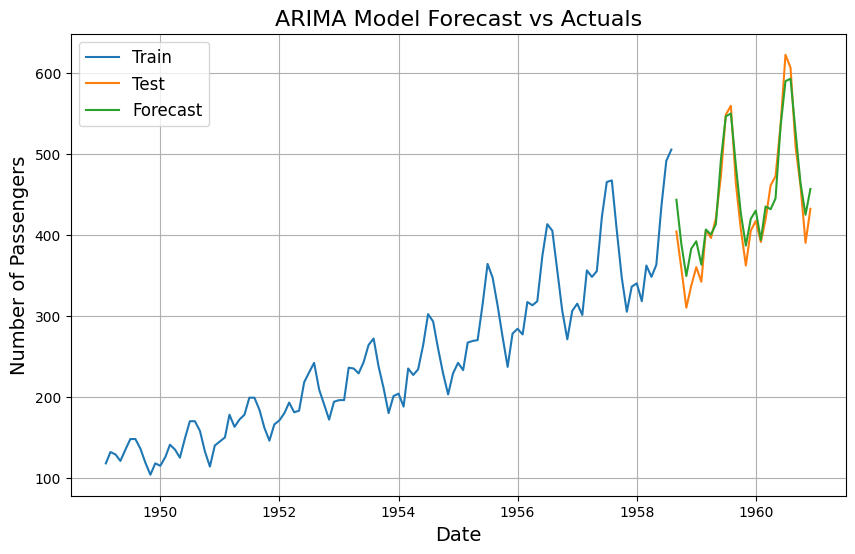

In [14]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:

    plt.figure(figsize=(10, 6))
    plt.plot(train['Month'], train['#Passengers'], label='Train')
    plt.plot(test['Month'], test['#Passengers'], label='Test')
    plt.plot(test['Month'], forecasts, label='Forecast')
    plt.title(f'{title} Model Forecast vs Actuals', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Passengers', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()    

# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')